# Addressing Business Challenges with Data: An Analysis of a Digital Media Store

## Project Overview

The goal of this project is to address business problems faced by a fictitious digital media store using data-driven approaches and provide actionable insights. To accomplish this, I used the [Chinook](https://github.com/lerocha/chinook-database) database, which contains tables for artists, albums, tracks, invoices, customers, and employees.

## Getting Started

Import the necessary libraries and make a connection to the database.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
conn = sqlite3.connect('Chinook_Sqlite.sqlite')

## Analysis
### Problem 1: Marketing Campaign

The Marketing Department plans to launch a new marketing campaign in three countries with high potential for growth. The department has asked us to identify these countries based on sales, customers, and invoices.

To identify the top three countries, I analyzed the sales distribution geographically and compared the number of customers and invoices across all countries. Here are the steps I took:

- Extracted data related to sales, customers, and invoices from the Chinook database using SQL
- Calculated the total sales amount, number of customers, and number of invoices for each country
- Ranked the countries based on total sales amount, number of customers, and number of invoices
- Identified the top three countries based on the ranking

In [11]:
# sales amount, number of customers, and number of invoices by country
q = '''
select BillingCountry as country, sum(Total) as total_sales,
    count(distinct CustomerId) as count_customers,
    count(distinct InvoiceId) as count_invoices
from Invoice
group by BillingCountry
order by 2 desc
limit 10
'''
sales = pd.read_sql(q, conn)
sales

,country,total_sales,count_customers,count_invoices
0,USA,523.06,13,91
1,Canada,303.96,8,56
2,France,195.10,5,35
3,Brazil,190.10,5,35
4,Germany,156.48,4,28
5,United Kingdom,112.86,3,21
6,Czech Republic,90.24,2,14
7,Portugal,77.24,2,14
8,India,75.26,2,13
9,Chile,46.62,1,7


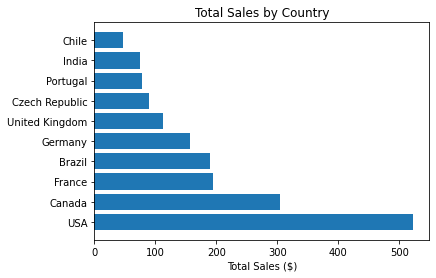

In [12]:
plt.barh(y='country', width='total_sales', data=sales)
plt.title('Total Sales by Country')
plt.xlabel('Total Sales ($)')
plt.show()

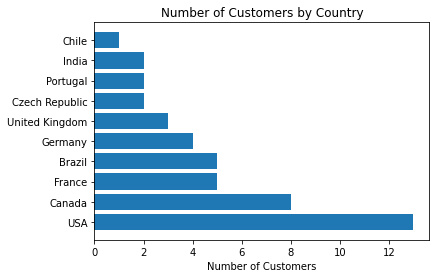

In [13]:
plt.barh(y='country', width='count_customers', data=sales)
plt.title('Number of Customers by Country')
plt.xlabel('Number of Customers')
plt.show()

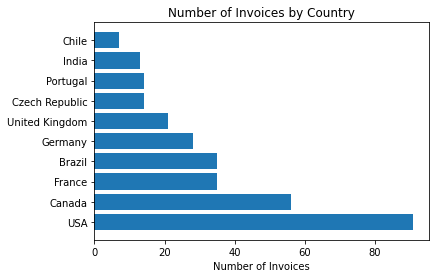

In [14]:
plt.barh(y='country', width='count_invoices', data=sales)
plt.title('Number of Invoices by Country')
plt.xlabel('Number of Invoices')
plt.show()

**Results and Recommendations**

- The top three countries by total sales amount are USA, Canada, and France.
- The ranking based on the number of customers and invoices is consistent with the ranking based on sales amount.
- France and Brazil have the same number of customers and invoices, but the total sales amount is slightly higher in France.

Based on these results, I recommend that the Marketing Department focuses on the USA, Canada, and France for the upcoming marketing campaign.

By focusing on the top three countries with the highest sales, customers, and invoices, the store can maximize the impact of the marketing campaign and increase the likelihood of its success.

### Problem 2: Sourcing Music Collection

The Sourcing Department plans to add more albums and tracks to the store's collection to increase sales. They have asked us to identify the most popular genres among customers and in the top three countries where the store generated the highest sales (USA, Canada, and France).

To identify the most popular genres, I analyzed the sales data by genre and compared the results across all customers and the top three countries. Here are the steps I took:

- Extracted data related to number of tracks sold from the Chinook database using SQL
- Calculated the number of tracks sold for each genre
- Ranked the genres based on number of tracks sold
- Compared the results across all customers and the top three countries

In [37]:
# number of tracks sold by genre
q = '''
select g.Name as genre, sum(Quantity) as tracks_sold
from InvoiceLine il
join Track t on t.TrackId = il.TrackId
join Genre g on g.GenreId = t.GenreId
group by g.Name
order by 2 desc
limit 10
'''

genre_all = pd.read_sql(q, conn)
genre_all

,genre,tracks_sold
0,Rock,835
1,Latin,386
2,Metal,264
3,Alternative & Punk,244
4,Jazz,80
5,Blues,61
6,TV Shows,47
7,R&B/Soul,41
8,Classical,41
9,Reggae,30


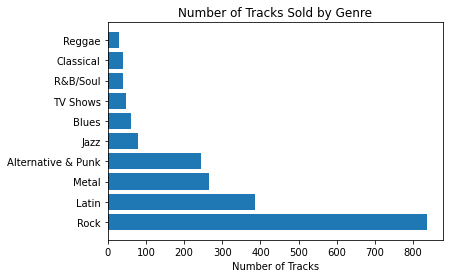

In [38]:
plt.barh(y='genre', width='tracks_sold', data=genre_all)
plt.title('Number of Tracks Sold by Genre')
plt.xlabel('Number of Tracks')
plt.show()

In [39]:
# number of tracks sold in USA, Canada, and France by genre
q = '''
with tbl as (
    select i.BillingCountry as country, g.Name as genre, sum(Quantity) as tracks_sold 
    from InvoiceLine il
    join Invoice i on i.InvoiceId = il.InvoiceId
    join Track t on t.TrackId = il.TrackId
    join Genre g on g.GenreId = t.GenreId
    group by i.BillingCountry, g.Name
)
select country, genre, tracks_sold
from (
    select *, row_number() over (partition by country order by tracks_sold desc) as rn
    from tbl
)
where country in ('USA', 'Canada', 'France')
and rn <= 3
'''

genre_top = pd.read_sql(q, conn)
genre_top

,country,genre,tracks_sold
0,Canada,Rock,107
1,Canada,Latin,60
2,Canada,Metal,40
3,France,Rock,65
4,France,Alternative & Punk,31
5,France,Latin,26
6,USA,Rock,157
7,USA,Latin,91
8,USA,Metal,64


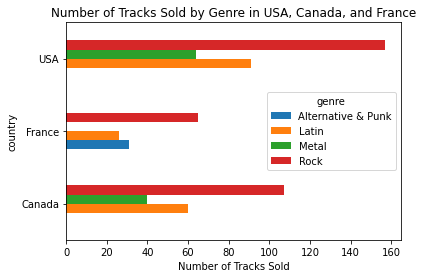

In [40]:
genre_top.pivot_table(index='country', columns='genre', values='tracks_sold').plot(kind='barh')
plt.xlabel('Number of Tracks Sold')
plt.title('Number of Tracks Sold by Genre in USA, Canada, and France')
plt.show()

**Results and Recommendations**

- The three most popular genres overall are Rock, Latin, and Metal.
- The same three genres are also the most popular in the top three countries (USA, Canada, and France), although the order varies slightly.
- In France, Alternative & Punk is the second most popular genre, followed by Latin in third place.

Based on these results, I recommend that the Sourcing Department purchases albums and tracks in the following genres: Rock, Latin, and Metal. These genres have a high chance of selling well among customers. They can also consider sourcing Alternative & Punk music, which has a great chance of selling well, particularly in France.

By adding more albums and tracks in the popular genres identified in this analysis, the store can attract new customers and increase sales revenue.

### Problem 3: Media Format Selection

The Product Department needs to decide on the most suitable media format in which the new songs will be made available on the website. The department wants to ensure that the chosen media format meets the customers' preferences and provides a high-quality listening experience.

To address this challenge, I analyzed customer preferences and investigate whether there are any country-specific insights that can inform the decision-making process. Here are the steps I took:

- Extracted data related to number of purchases from the Chinook database using SQL
- Calculated the number of purchases for each media type
- Ranked the media types based on the number of purchases
- Examined the preferred media type in each country using the same approach as above

In [44]:
# number of tracks sold by media type
q = '''
select m.Name as media_type, sum(Quantity) as tracks_sold
from InvoiceLine il
join Track t on t.TrackId = il.TrackId
join MediaType m on m.MediaTypeId = t.MediaTypeId
group by m.Name
order by 2 desc
limit 10
'''
media_all = pd.read_sql(q, conn)
media_all

,media_type,tracks_sold
0,MPEG audio file,1976
1,Protected AAC audio file,146
2,Protected MPEG-4 video file,111
3,Purchased AAC audio file,4
4,AAC audio file,3


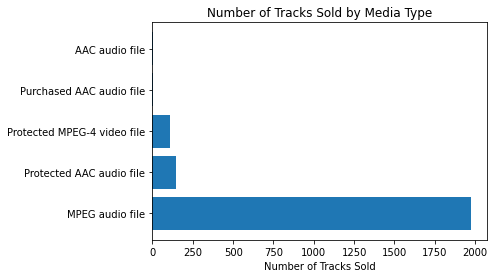

In [46]:
plt.barh('media_type', 'tracks_sold', data=media_all)
plt.title('Number of Tracks Sold by Media Type')
plt.xlabel('Number of Tracks Sold')
plt.show()

In [48]:
# preferred media type in each country
q = '''
with tbl as (
    select i.BillingCountry as country, m.Name as media_type, sum(Quantity) as tracks_sold 
    from InvoiceLine il
    join Invoice i on i.InvoiceId = il.InvoiceId
    join Track t on t.TrackId = il.TrackId
    join MediaType m on m.MediaTypeId = t.MediaTypeId
    group by i.BillingCountry, m.Name
)
select country, media_type, tracks_sold
from (
    select *, row_number() over (partition by country order by tracks_sold desc) as rn
    from tbl
)
where rn = 1
'''
type_per_country = pd.read_sql(q, conn)
type_per_country

,country,media_type,tracks_sold
0,Argentina,MPEG audio file,36
1,Australia,MPEG audio file,38
2,Austria,MPEG audio file,25
3,Belgium,MPEG audio file,38
4,Brazil,MPEG audio file,170
5,Canada,MPEG audio file,289
6,Chile,MPEG audio file,28
7,Czech Republic,MPEG audio file,57
8,Denmark,MPEG audio file,32
9,Finland,MPEG audio file,34


**Results and Recommendations**
- The preferred media type by customers was MPEG audio file, 
- MPEG audio file was consistently the top choice across all countries. 
- There were no significant country-specific trends or preferences for media format.

Based on these results, I recommend that the new tracks be made available in MPEG audio file format on the website. The preference for MPEG audio files is consistent across all countries, indicating that this media format is universally preferred by the store's customer base.

By implementing this recommendation, the store can ensure that the customers are satisfied and can enjoy the new tracks in their preferred format.

### Problem 4: Employee Performance

The General Manager of the Sales Department at Chinook is looking to expand the department in anticipation of new customers. Among the current employees, there are three sales support agents and one sales manager. The General Manager is considering promoting one of the sales support agents to the position of sales manager, based on their past sales performance.

To identify the best-performing employee, I analyzed the sales performance of each employee and look for trends in their performance over the years. Here are the steps I took:

- Extracted sales data from the Chinook database using SQL
- Calculated the total sales generated by each employee
- Analyzed the sales performance of each employee over the years to identify any trends

In [61]:
# overall employee performance
q = '''
select e.FirstName || ' ' || e.LastName as employee_name, e.HireDate as hire_date,
    sum(i.Total) as total_sales
from Invoice i
join Customer c on c.CustomerId = i.CustomerId
join Employee e on c.SupportRepId = e.EmployeeId
group by e.EmployeeId
'''

employee_all = pd.read_sql(q, conn)
employee_all

,employee_name,hire_date,total_sales
0,Jane Peacock,2002-04-01 00:00:00,833.04
1,Margaret Park,2003-05-03 00:00:00,775.40
2,Steve Johnson,2003-10-17 00:00:00,720.16


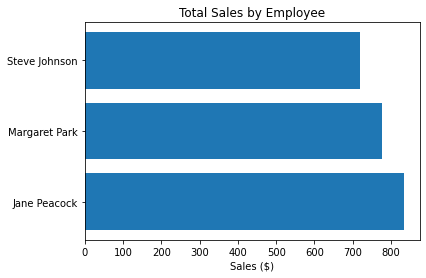

In [52]:
plt.barh('employee_name', 'total_sales', data=employee_all)
plt.title('Total Sales by Employee')
plt.xlabel('Sales ($)')
plt.show()

In [63]:
# employee performance over the years
q = '''
select employee_name, invoice_year, sum(Total) as total_sales
from (
select e.FirstName || ' ' || e.LastName as employee_name, strftime('%Y', InvoiceDate) as invoice_year, i.Total
from Invoice i
join Customer c on c.CustomerId = i.CustomerId
join Employee e on e.EmployeeId = c.SupportRepId
)
group by employee_name, invoice_year
'''
employee_yearly = pd.read_sql(q, conn)
employee_yearly

,employee_name,invoice_year,total_sales
0,Jane Peacock,2009,123.75
1,Jane Peacock,2010,221.92
2,Jane Peacock,2011,184.34
3,Jane Peacock,2012,146.60
4,Jane Peacock,2013,156.43
5,Margaret Park,2009,161.37
6,Margaret Park,2010,122.76
7,Margaret Park,2011,125.77
8,Margaret Park,2012,197.20
9,Margaret Park,2013,168.30


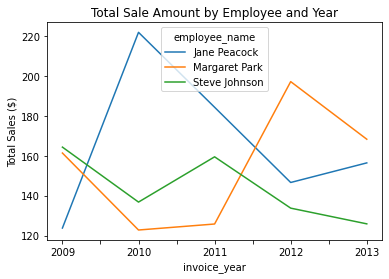

In [67]:
employee_yearly.pivot_table(index='invoice_year', columns='employee_name', values='total_sales').plot(kind='line')
plt.title('Total Sale Amount by Employee and Year')
plt.ylabel('Total Sales ($)')
plt.show()

**Results and Recommendations**

- The best-performing employee is Jane Peacock, with a total sales revenue of \$833.04.
- Margaret Park and Steve Johnson generated total sales revenues of \\$775.40 and \$720.16, respectively.
- Jane Peacock has consistently outperformed the other employees in terms of total sales revenue, except in 2012 and 2013.

Based on these results, I recommend promoting Jane Peacock to the position of sales manager based on her consistent and strong sales performance over the years. 

It is important to note, however, that the recommendation only considered the total sales revenue generated by each employee and did not take into account significant factors such as customer satisfaction, product knowledge, and leadership skills.

### Problem 5: Customer Loyalty Program

The Marketing Department wants to implement a loyalty program to retain customers and keep them engaged. The loyalty program will offer discounts and freebies to the best customers of the store. The department needs to identify the customers with the highest total purchase amount and the highest spender in each country to create a more targeted campaign for them.

To identify the best customers, I analyzed the data to determine the ones with the highest total purchase amount and the highest spenders per country. Here are the steps I took:

- Extracted data related to customer spending from the Chinook database using SQL
- Calculated the total amount spent by each customer
- Ranked the customers based on their total spending
- Determined the highest spender in each country

In [76]:
# highest spenders overall
q = '''
select *
from (
select c.FirstName || ' ' || c.LastName as customer_name, c.City as city, c.Country as country, 
    sum(i.Total) as total_spending,
    dense_rank() over (order by sum(i.Total) desc) as rk
from Invoice i
join Customer c on i.CustomerId = c.CustomerId
group by i.CustomerId
)
where rk <= 10
'''
spending_all = pd.read_sql(q, conn)
spending_all

,customer_name,city,country,total_spending,rk
0,Helena Holý,Prague,Czech Republic,49.62,1
1,Richard Cunningham,Fort Worth,USA,47.62,2
2,Luis Rojas,Santiago,Chile,46.62,3
3,Ladislav Kovács,Budapest,Hungary,45.62,4
4,Hugh O'Reilly,Dublin,Ireland,45.62,4
5,Julia Barnett,Salt Lake City,USA,43.62,5
6,Frank Ralston,Chicago,USA,43.62,6
7,Fynn Zimmermann,Frankfurt,Germany,43.62,6
8,Astrid Gruber,Vienne,Austria,42.62,7
9,Victor Stevens,Madison,USA,42.62,7


In [80]:
# highest spenders by country
q = '''
with tbl as (
select CustomerId, sum(Total) as Total,
    dense_rank() over (partition by BillingCountry order by sum(Total) desc) as rk
from Invoice
group by BillingCountry, CustomerId
)

select c.FirstName || ' ' || c.LastName as customer_name, c.City as city, c.Country as country,
    t.Total as total_spending
from tbl t
join Customer c on t.CustomerId = c.CustomerId
where rk = 1
'''
spending_country = pd.read_sql(q, conn)
spending_country

,customer_name,city,country,total_spending
0,Diego Gutiérrez,Buenos Aires,Argentina,37.62
1,Mark Taylor,Sidney,Australia,37.62
2,Astrid Gruber,Vienne,Austria,42.62
3,Daan Peeters,Brussels,Belgium,37.62
4,Luís Gonçalves,São José dos Campos,Brazil,39.62
5,François Tremblay,Montréal,Canada,39.62
6,Luis Rojas,Santiago,Chile,46.62
7,Helena Holý,Prague,Czech Republic,49.62
8,Kara Nielsen,Copenhagen,Denmark,37.62
9,Terhi Hämäläinen,Helsinki,Finland,41.62


**Results and Recommendations**

- The top spender is from Czech Republic. 
- Four of the top 10 spenders come from different parts of the US.
- The rest are from South America and Europe.

Based on the total purchase amount, the customers with the highest spending should be selected for the upcoming loyalty program. 

It is recommended that the store gather more information about their customers, such as age and gender, as it can be used to derive more actionable insights. By segmenting the customers based on their demographics, the Marketing Department can create more tailored marketing programs for each group of customers.

## Conclusion

In this project, I used data-driven approaches to provide actionable insights to a fictitious digital media store, Chinook, to address its business problems. The analysis focused on five problems: Marketing Campaign, Sourcing Music Selection, Media Format Selection, Employee Performance, and Customer Loyalty Program. Overall, the results can help Chinook improve its marketing campaigns, attract new customers, increase sales revenue, and retain its current customer base.

Through this project, I was able to demonstrate my proficiency in data manipulation, data analysis, and data visualization using SQL and Python, specifically the pandas and matplotlib libraries. I was also able to showcase my ability to provide meaningful insights and recommendations to address complex business problems.